In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
pip install geopandas

In [3]:
import json
import pandas as pd
import numpy as np
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumBarunGothic') 

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#서울 행정구역 나누기
korea = gpd.GeoDataFrame.from_file('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/korea', encoding='cp949')

seoul = korea.iloc[:25]
seoul.drop(['SIG_CD','SIG_ENG_NM'],axis=1, inplace=True)
seoul= seoul.to_crs(epsg=4326)

# cctv

## 데이터생성

In [ ]:
cctv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/CCTV_위치.csv.csv')
cctv

,자치구,위도,경도,CCTV 수량
0,중랑구,37.613669,127.075354,1
1,중랑구,37.613293,127.078697,1
2,중랑구,37.613041,127.074501,1
3,중랑구,37.591652,127.100220,1
4,중랑구,37.612949,127.075500,1
...,...,...,...,...
61538,강남구,37.493380,127.074600,1
61539,강남구,37.510575,127.048103,1
61540,강남구,37.510575,127.048103,1
61541,강남구,37.493402,127.047153,1


## 지도시각화

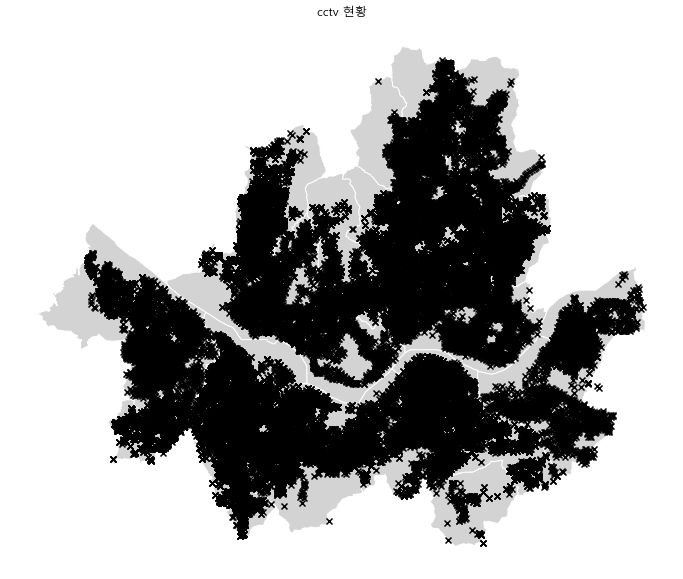

In [ ]:
cctv=gpd.GeoDataFrame(cctv, geometry=gpd.points_from_xy(cctv['경도'], cctv['위도']))
cctv.crs = {'init':'epsg:4326'}

ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
cctv.plot(ax=ax, marker='x',color='black')
plt.title('cctv 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = cctv.iloc[:,[2,1]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 104.25445269681178
k: 6 inerita: 82.9254081823796
k: 7 inerita: 70.46180064473305
k: 8 inerita: 58.18450900415857
k: 9 inerita: 50.03033915786888
k: 10 inerita: 45.460715810534744
k: 11 inerita: 41.47235503234939
k: 12 inerita: 38.15706292093679
k: 13 inerita: 34.44156474583335
k: 14 inerita: 31.643930337048904
k: 15 inerita: 29.06783903570796
k: 16 inerita: 26.83024538139393
k: 17 inerita: 24.847803554363914
k: 18 inerita: 23.21089555609279
k: 19 inerita: 22.13889570271154


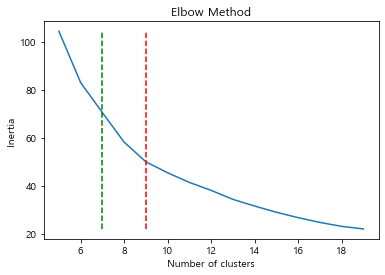

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(7, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(9, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(7,10)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 7 score: 0.4234354323919201
k: 8 score: 0.4435161590659609
k: 9 score: 0.43408509329843464
best n: 8 best score: 0.4435161590659609


### 최적의 군집 개수로 군집화

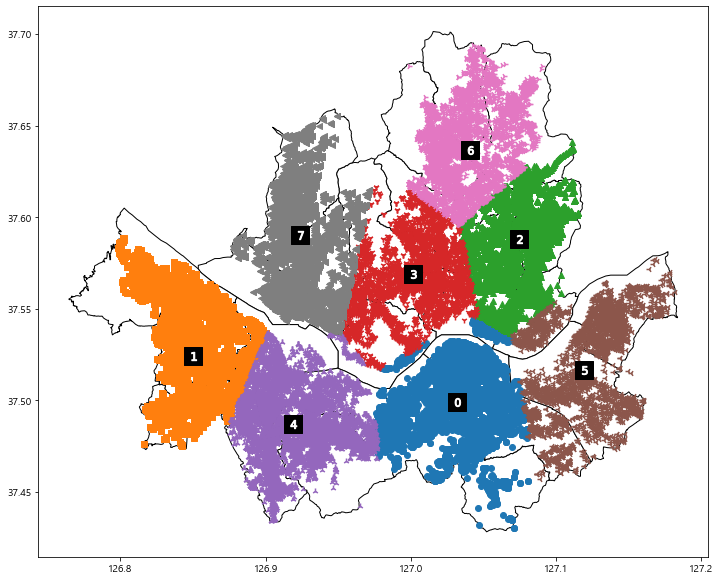

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

cctv_cluster = cctv.iloc[:,[2,1]]
kmeans = KMeans(n_clusters=8, init ='k-means++', max_iter = 300, random_state=0)

cctv_cluster['target'] = kmeans.fit_predict(cctv_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','4','<','>','d','h','D','H']
for i in np.unique(cctv_cluster.target):
    target = cctv_cluster[cctv_cluster.target == i]        
    plt.scatter(x=target['경도'], y=target['위도'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## cctv 자치구별 히트맵

In [ ]:
cctv_cnt = (cctv.groupby('자치구')['CCTV 수량'].count())
cctv_cnt_heat = pd.merge(seoul,cctv_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')
cctv_cnt_heat

,SIG_KOR_NM,geometry,CCTV 수량
0,종로구,"POLYGON ((127.00864 37.58047, 127.00871 37.580...",1648
1,중구,"POLYGON ((127.02314 37.57196, 127.02336 37.571...",2317
2,용산구,"POLYGON ((126.96918 37.55566, 126.96917 37.554...",908
3,성동구,"POLYGON ((127.04341 37.57234, 127.04524 37.571...",1256
4,광진구,"POLYGON ((127.10166 37.57240, 127.10224 37.572...",911
5,동대문구,"POLYGON ((127.07108 37.60732, 127.07117 37.606...",2628
6,중랑구,"POLYGON ((127.11131 37.62069, 127.11214 37.620...",3740
7,성북구,"POLYGON ((127.01059 37.58025, 127.01030 37.580...",3625
8,강북구,"POLYGON ((127.00457 37.68508, 127.00553 37.684...",1525
9,도봉구,"POLYGON ((127.01509 37.64929, 127.01477 37.649...",1178


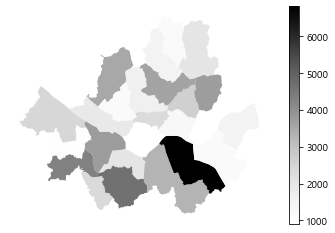

In [ ]:
fig, ax = plt.subplots(1, 1)

cctv_cnt_heat.plot('CCTV 수량', ax=ax, legend=True, cmap='Greys' )

plt.axis('off')
plt.show()

# 유흥주점

## 데이터생성

In [ ]:
bar = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/유흥주점.xlsx',usecols = [7,15])
bar = bar.query('상세영업상태명 == "영업"')

# 이상치 제거
bar.dropna(inplace = True)
bar.reset_index(drop = True, inplace=True)

In [ ]:
bar

,상세영업상태명,지번주소
0,영업,서울특별시 은평구 갈현동 395-28
1,영업,서울특별시 도봉구 창동 12-1 2층 201202203204호
2,영업,서울특별시 강북구 수유동 191-15
3,영업,서울특별시 강동구 길동 387-7
4,영업,서울특별시 송파구 가락동 99-2 지상2층
...,...,...
1795,영업,서울특별시 금천구 시흥동 954-32 지하1층
1796,영업,서울특별시 금천구 독산동 293-5
1797,영업,서울특별시 영등포구 영등포동3가 17-9 스카이모텔
1798,영업,서울특별시 서초구 잠원동 21-3 4호 (지하 1층)


In [ ]:
bar['Longitude'] = ''
bar['Latitude'] = ''
drop_li = []

import requests

for i in range(len(bar)):
    try:
        url= "http://api.vworld.kr/req/address?"
        key = 'F2FA331D-A1EB-337A-ACF7-A42DBF7AA247'
        address = bar['지번주소'][i]
        params ={'service': "address", 
                'request': "getcoord", 'version' : '2.0',
                'type' : 'PARCEL',
                'crs' : 'epsg:4326', 'format' : 'json',
                'address': address,
                'key' : key}
    
        res = requests.get(url, params = params)
        json_data = res.json()

        if json_data['response']['status'] == 'OK':
            bar['Longitude'][i] = json_data['response']['result']['point']['x']
            bar['Latitude'][i] = json_data['response']['result']['point']['y']
            
    except:
        drop_li.append(i) 

In [ ]:
bar.drop(bar.query('Longitude=="" or Latitude==""').index, inplace=True)
bar.reset_index(drop=True, inplace=True)

In [ ]:
bar['자치구'] = bar['지번주소'].str.split(' ').str[1]

## 지도 시각화

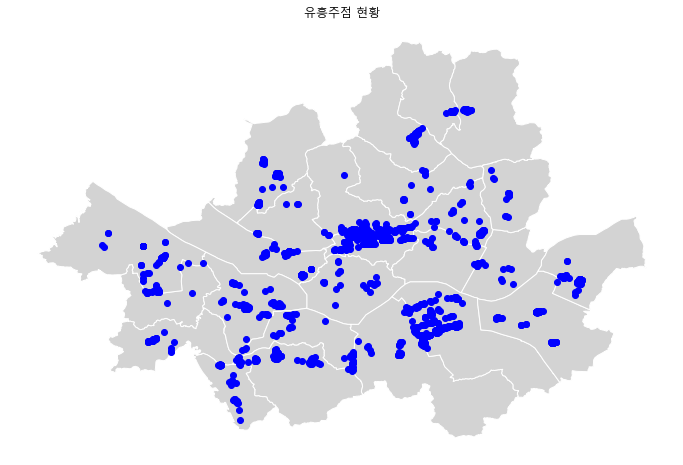

In [ ]:
bar=gpd.GeoDataFrame(bar,geometry=gpd.points_from_xy(bar['Longitude'], bar['Latitude']))

ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
bar.plot(ax=ax, marker='o',color='blue')
plt.title('유흥주점 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = bar.iloc[:,[2,3]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 2.588500897325124
k: 6 inerita: 1.7787728325259249
k: 7 inerita: 1.2785414783499525
k: 8 inerita: 0.9894419441286116
k: 9 inerita: 0.8067241066235981
k: 10 inerita: 0.6775521825867936
k: 11 inerita: 0.5980980030706058
k: 12 inerita: 0.5176680616294752
k: 13 inerita: 0.4526388452788344
k: 14 inerita: 0.3947434025242445
k: 15 inerita: 0.34974266545710064
k: 16 inerita: 0.3234187701158866
k: 17 inerita: 0.3084962067309794
k: 18 inerita: 0.2724874741425086
k: 19 inerita: 0.2548088875802055


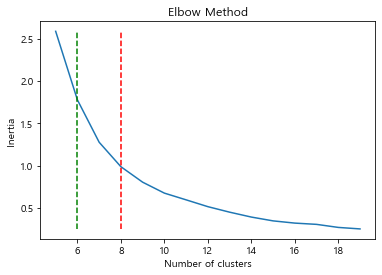

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(6, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(8, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(6,9)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 6 score: 0.5409696952955336
k: 7 score: 0.5874261455495737
k: 8 score: 0.61166429710332
best n: 8 best score: 0.61166429710332


### 최적의 군집 개수로 군집화

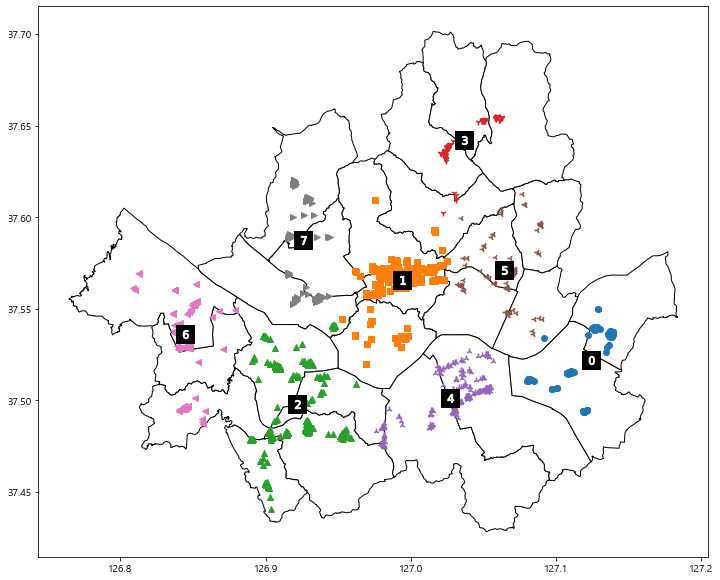

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

bar_cluster = bar.iloc[:,[2,3]].astype('float')
kmeans = KMeans(n_clusters=8, init ='k-means++', max_iter = 300, random_state=0)

bar_cluster['target'] = kmeans.fit_predict(bar_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','<','>','d','h']
for i in np.unique(bar_cluster.target):
    target = bar_cluster[bar_cluster.target == i]        
    plt.scatter(x=target['Longitude'], y=target['Latitude'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## 유흥주점 자치구별 히트맵

In [ ]:
bar_cnt = bar.groupby('자치구').agg(count = ('자치구', 'count'))
bar_cnt.reset_index(inplace = True)
bar_cnt

,자치구,count
0,강남구,177
1,강동구,108
2,강북구,67
3,강서구,126
4,관악구,189
5,광진구,14
6,구로구,31
7,금천구,44
8,노원구,21
9,도봉구,21


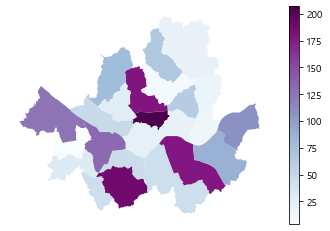

In [ ]:
bar_cnt_heat = pd.merge(seoul,bar_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')

fig, ax = plt.subplots(1, 1)

bar_cnt_heat.plot('count', ax=ax, legend=True, cmap='BuPu')
plt.axis('off')
plt.show()

# 단속카메라

## 데이터생성

In [ ]:
speed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/단속카메라_위치.csv', 
                    header =1, 
                    names = ['시도명','자치구','Latitude','Longitude'])
speed

,시도명,자치구,Latitude,Longitude
0,서울특별시,은평구,37.583214,126.893992
1,서울특별시,은평구,37.600916,126.931996
2,서울특별시,은평구,37.631990,126.925787
3,서울특별시,은평구,37.612094,126.920067
4,서울특별시,은평구,37.603266,126.927312
...,...,...,...,...
1855,서울특별시,광진구,37.537341,127.093867
1856,서울특별시,성북구,37.609888,127.022593
1857,서울특별시,금천구,37.444682,126.901072
1858,서울특별시,서대문구,37.572866,126.908370


## 지도시각화

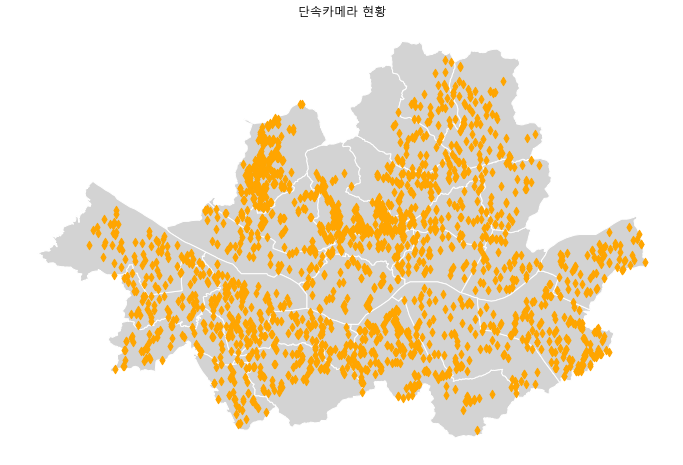

In [ ]:
speed=gpd.GeoDataFrame(speed,geometry=gpd.points_from_xy(speed['Longitude'], speed['Latitude']))

ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
speed.plot(ax=ax, marker='d',color='orange')
plt.title('단속카메라 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = speed.iloc[:,[3,2]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 3.358405408883491
k: 6 inerita: 2.7639961631501673
k: 7 inerita: 2.1844660786941734
k: 8 inerita: 1.9226569621493896
k: 9 inerita: 1.7267213305674958
k: 10 inerita: 1.5641906316226366
k: 11 inerita: 1.396176512579997
k: 12 inerita: 1.2675220087358987
k: 13 inerita: 1.1813672553954253
k: 14 inerita: 1.0907596474043202
k: 15 inerita: 1.0007272541056258
k: 16 inerita: 0.9310913453134877
k: 17 inerita: 0.8568010618987364
k: 18 inerita: 0.802901501946077
k: 19 inerita: 0.764080721472567


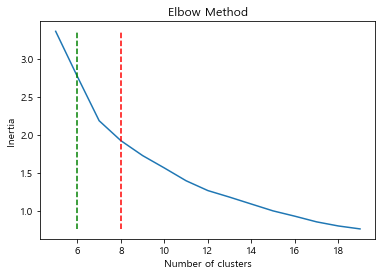

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(6, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(8, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(6,9)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 6 score: 0.4346399223791234
k: 7 score: 0.4418162568626507
k: 8 score: 0.43443607093474473
best n: 7 best score: 0.4418162568626507


### 최적의 군집 개수로 군집화

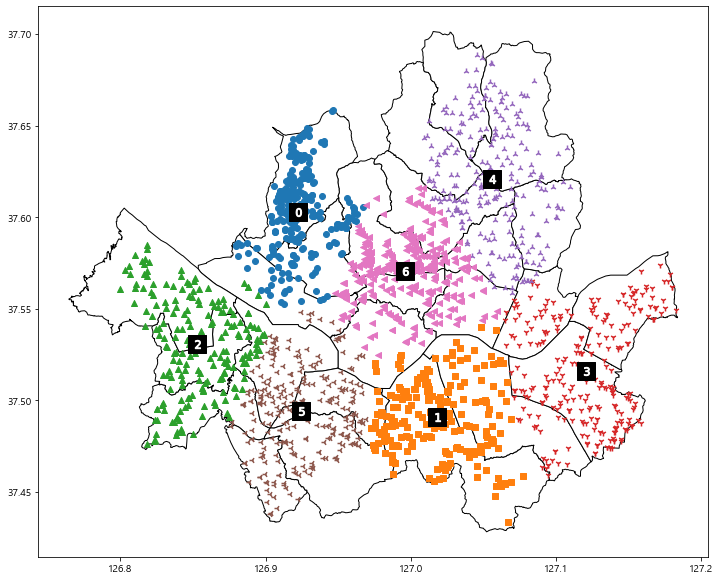

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

speed_cluster = speed.iloc[:,[3,2]].astype('float')
kmeans = KMeans(n_clusters=7, init ='k-means++', max_iter = 300, random_state=0)
kmeans.fit(speed_cluster)

speed_cluster['target'] = kmeans.fit_predict(speed_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','<','>','d','h']
for i in np.unique(speed_cluster.target):
    target = speed_cluster[speed_cluster.target == i]        
    plt.scatter(x=target['Longitude'], y=target['Latitude'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## 단속카메라 자치구별 히트맵

In [ ]:
speed_cnt = speed.groupby('자치구').agg(count = ('자치구', 'count'))
speed_cnt.reset_index(inplace = True)
speed_cnt

,자치구,count
0,강남구,78
1,강동구,69
2,강북구,29
3,강서구,69
4,관악구,77
5,광진구,46
6,구로구,58
7,금천구,40
8,노원구,67
9,도봉구,35


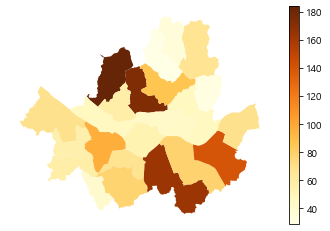

In [ ]:
speed_cnt_heat = pd.merge(seoul,speed_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')

fig, ax = plt.subplots(1, 1)

speed_cnt_heat.plot('count', ax=ax, legend=True, cmap='YlOrBr')
plt.axis('off')
plt.show()

# 어린이 보호구역

## 데이터생성

In [ ]:
protect = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/어린이보호구역_위치.csv')
protect

,주소,Longitude,Latitude,자치구
0,서울특별시 강서구 마곡서로 33 (마곡동),126.822611,37.557822,강서구
1,서울특별시 강서구 강서로 216-23,126.837554,37.545734,강서구
2,서울특별시 강서구 강서로15길 40 (화곡동),126.843815,37.532302,강서구
3,서울특별시 강서구 강서로17길 130 (화곡동),126.838533,37.532117,강서구
4,서울특별시 강서구 강서로31길 48 (화곡동),126.839074,37.540102,강서구
...,...,...,...,...
1554,서울시 노원구 중계1동361-1,127.072740,37.646745,노원구
1555,서울시 노원구 하계1동 288-1,127.073343,37.644399,노원구
1556,서울시 노원구 공릉로58길 24,127.073135,37.633957,노원구
1557,서울시 노원구 공릉로59가길 13,127.070927,37.634068,노원구


## 지도시각화

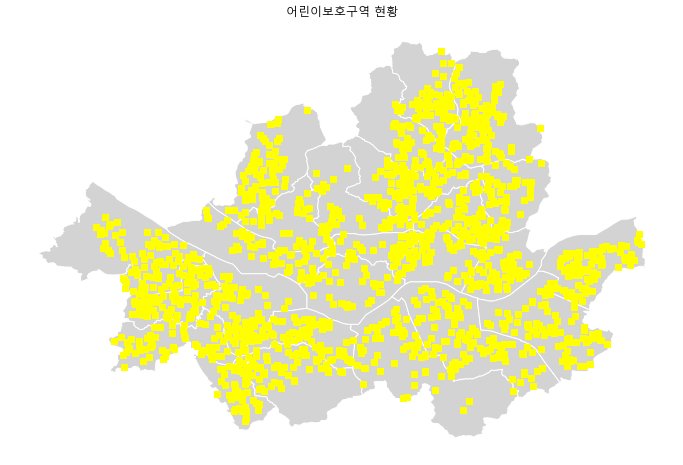

In [ ]:
protect=gpd.GeoDataFrame(protect,geometry=gpd.points_from_xy(protect['Longitude'], protect['Latitude']))
ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
protect.plot(ax=ax, marker='s',color='yellow')
plt.title('어린이보호구역 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = protect.iloc[:,[1,2]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 2.802306997297613
k: 6 inerita: 2.148066260177801
k: 7 inerita: 1.7754406390335515
k: 8 inerita: 1.5361726134180398
k: 9 inerita: 1.3419957947011611
k: 10 inerita: 1.2242699951959228
k: 11 inerita: 1.1428707144041892
k: 12 inerita: 1.0320217609833515
k: 13 inerita: 0.9477281461999757
k: 14 inerita: 0.8560966691197254
k: 15 inerita: 0.7835483408606132
k: 16 inerita: 0.7420901137447393
k: 17 inerita: 0.6945112483153646
k: 18 inerita: 0.6487985956167892
k: 19 inerita: 0.6062881528676702


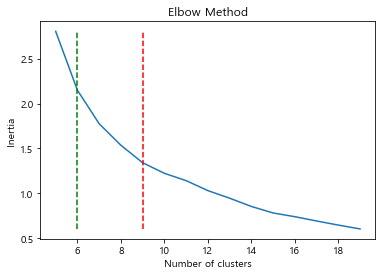

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(6, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(9, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(6,10)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 6 score: 0.43956703272729064
k: 7 score: 0.4320261703734359
k: 8 score: 0.44212434853718724
k: 9 score: 0.42971909001095715
best n: 8 best score: 0.44212434853718724


### 최적의 군집 개수로 군집화

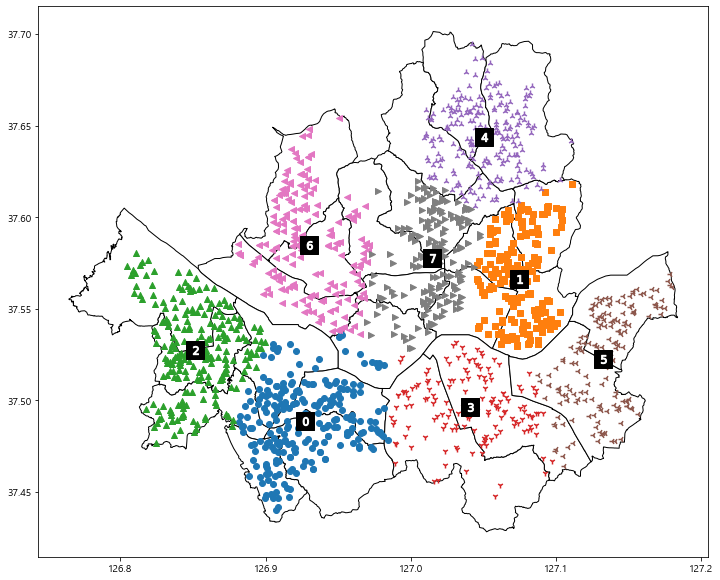

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

protect_cluster = protect.iloc[:,[1,2]].astype('float')
kmeans = KMeans(n_clusters=8, init ='k-means++', max_iter = 300, random_state=0)
kmeans.fit(protect_cluster)

protect_cluster['target'] = kmeans.fit_predict(protect_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','<','>','d','h']
for i in np.unique(protect_cluster.target):
    target = protect_cluster[protect_cluster.target == i]        
    plt.scatter(x=target['Longitude'], y=target['Latitude'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## 보호구역 자치구별 히트맵

In [ ]:
protect_cnt = protect.groupby('자치구').agg(count = ('자치구', 'count'))
protect_cnt.reset_index(inplace = True)
protect_cnt

,자치구,count
0,강남구,100
1,강동구,82
2,강북구,40
3,강서구,68
4,관악구,65
5,광진구,80
6,구로구,59
7,금천구,45
8,노원구,100
9,도봉구,64


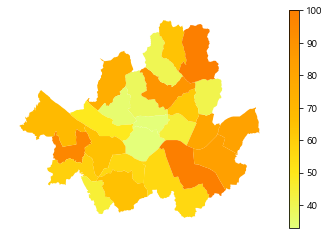

In [ ]:
protect_cnt_heat = pd.merge(seoul,protect_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')

fig, ax = plt.subplots(1, 1)

protect_cnt_heat.plot('count', ax=ax, legend=True, cmap='Wistia')
plt.axis('off')
plt.show()

# 병원

## 데이터생성

In [ ]:
df_H = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/병의원.csv',
                   usecols = [1,3,31,32], 
                   names = ['주소','병원분류명','Longitude','Latitude'])

hospital = df_H.query("병원분류명 in ['의원','병원','종합병원']")
hospital.reset_index(drop=True, inplace=True)

hospital['자치구'] = hospital['주소'].str.split(' ').str[1]

## 지도 시각화

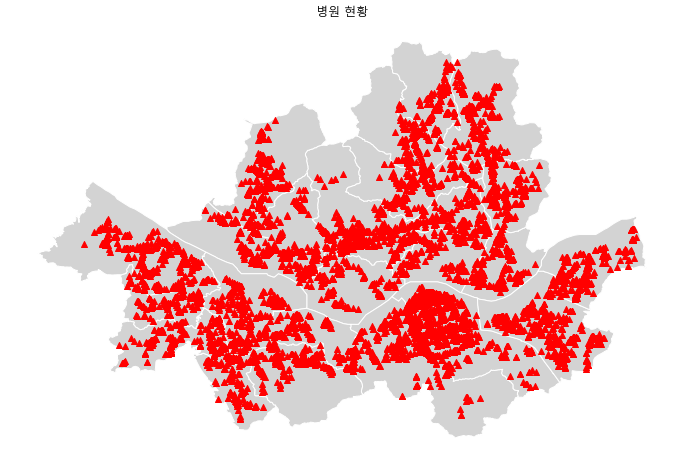

In [ ]:
hospital=gpd.GeoDataFrame(hospital,geometry=gpd.points_from_xy(hospital['Longitude'], hospital['Latitude']))

ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
hospital.plot(ax=ax, marker='^',color='red')
plt.title('병원 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = hospital.iloc[:,[2,3]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 14.618029601168404
k: 6 inerita: 11.163935045025605
k: 7 inerita: 9.377425374191212
k: 8 inerita: 8.0801099853443
k: 9 inerita: 7.121201934799938
k: 10 inerita: 6.422451681974652
k: 11 inerita: 5.726725312035097
k: 12 inerita: 5.292640759971968
k: 13 inerita: 4.882966425390525
k: 14 inerita: 4.419476547141416
k: 15 inerita: 4.045879828968913
k: 16 inerita: 3.743155726420695
k: 17 inerita: 3.4726926610645843
k: 18 inerita: 3.1700054732435605
k: 19 inerita: 3.0099304916906577


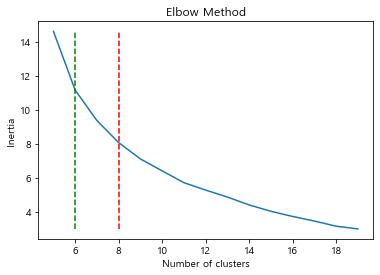

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(6, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(8, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(6,9)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 6 score: 0.49551362601391086
k: 7 score: 0.4788544555775474
k: 8 score: 0.48459860472165506
best n: 6 best score: 0.49551362601391086


### 최적의 군집 개수로 군집화

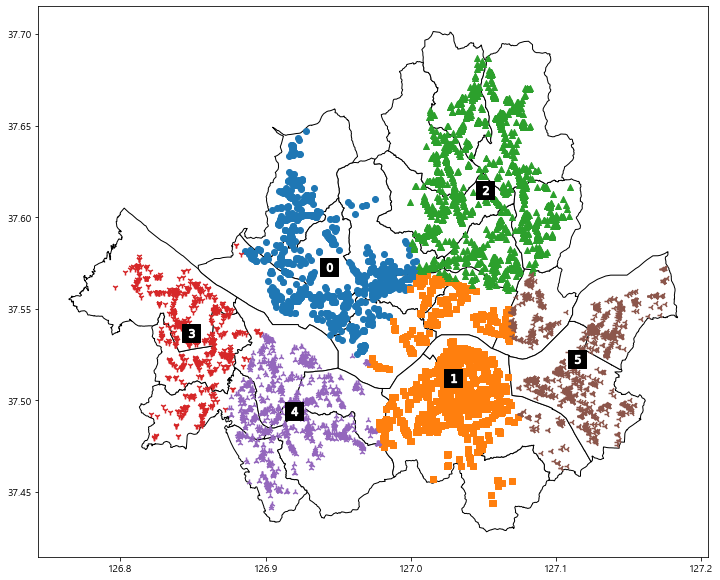

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

hospital_cluster = hospital.iloc[:,[2,3]].astype('float')
kmeans = KMeans(n_clusters=6, init ='k-means++', max_iter = 300, random_state=0)
kmeans.fit(hospital_cluster)

hospital_cluster['target'] = kmeans.fit_predict(hospital_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','<','>','d','h']
for i in np.unique(hospital_cluster.target):
    target = hospital_cluster[hospital_cluster.target == i]        
    plt.scatter(x=target['Longitude'], y=target['Latitude'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## 병원 자치구별 히트맵

In [ ]:
hospital_cnt = hospital.groupby('자치구').agg(count = ('자치구', 'count'))
hospital_cnt.reset_index(inplace = True)
hospital_cnt

,자치구,count
0,강남구,1960
1,강동구,441
2,강북구,243
3,강서구,485
4,관악구,354
5,광진구,292
6,구로구,286
7,금천구,179
8,노원구,394
9,도봉구,178


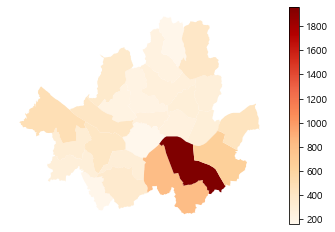

In [ ]:
H_cnt_heat = pd.merge(seoul,hospital_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')

fig, ax = plt.subplots(1, 1)

H_cnt_heat.plot('count', ax=ax, legend=True, cmap='OrRd')
plt.axis('off')
plt.show()

# 돌봄센터

## 데이터 생성

In [ ]:
df_care1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/열린육아방.csv', usecols = [1,5,7,8,9])
df_care2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/우리동네키움센터.csv', usecols = [1,5,7,8,9])
df_care3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/지역아동센터.csv',usecols = [1,5,7,8,9])

care = pd.concat([df_care1,df_care2,df_care3])
care.dropna(inplace = True)
care.reset_index(drop=True, inplace=True)
care.columns = ['시설명','자치구','연령구분','Longitude','Latitude']
care.to_csv('/content/drive/MyDrive/Colab Notebooks/1차프로젝트/data/돌봄센터.csv', index = False)

In [ ]:
care

,시설명,자치구,연령구분,Longitude,Latitude
0,목동깨비 공동육아방,양천구,영유아,126.863720,37.548270
1,미아 공동육아방,강북구,영유아,127.025950,37.632420
2,망우자람 공동육아방,중랑구,영유아,127.098166,37.592338
3,맘스하트카페 흑석동2호점,동작구,영유아,126.960610,37.505120
4,맘스하트카페 상도2동점,동작구,영유아,126.946078,37.501416
...,...,...,...,...,...
736,한사랑지역아동센터,금천구,초등학생,126.900320,37.449900
737,금강지역아동센터,구로구,초등학생,126.855620,37.500780
738,하모니지역아동센터,구로구,초등학생,126.854320,37.488720
739,강남지역아동센터,강남구,초등학생,127.049750,37.478300


## 지도시각화

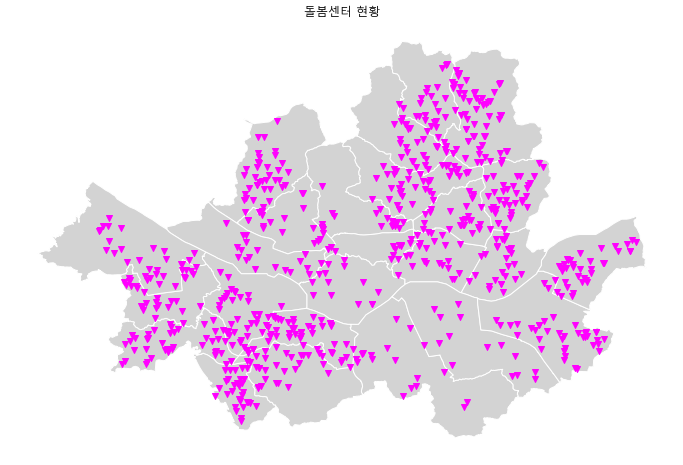

In [ ]:
care=gpd.GeoDataFrame(care,geometry=gpd.points_from_xy(care['Longitude'], care['Latitude']))

ax = seoul.plot(color='lightgrey',edgecolor='white',figsize=(12,12))
care.plot(ax=ax, marker='v',color='magenta')
plt.title('돌봄센터 현황')
plt.axis('off')
plt.show()

## Clustering_Kmeans

### 최적의 군집 개수 결정

#### Elbow 기법

In [ ]:
X_train = care.iloc[:,[3,4]]

inertia_arr = []
k_range = range(5,20)
for k in k_range:
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(X_train)
    interia = Kmeans.inertia_
    
    print('k:', k, 'inerita:', interia)
    inertia_arr.append(interia)
inertia_arr = np.array(inertia_arr)

k: 5 inerita: 1.2691251806569843
k: 6 inerita: 1.001502302860422
k: 7 inerita: 0.8365437707443671
k: 8 inerita: 0.7073330671525803
k: 9 inerita: 0.6254450190288191
k: 10 inerita: 0.5750980660170064
k: 11 inerita: 0.5290148260078563
k: 12 inerita: 0.47856593945318965
k: 13 inerita: 0.4343739532559439
k: 14 inerita: 0.38578113559936034
k: 15 inerita: 0.33962156768203633
k: 16 inerita: 0.321554698129318
k: 17 inerita: 0.2989168962497952
k: 18 inerita: 0.2810762814816194
k: 19 inerita: 0.2654174849746256


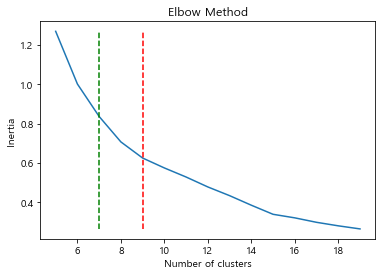

In [ ]:
plt.plot(k_range, inertia_arr)

plt.vlines(7, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'g')
plt.vlines(9, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors = 'r')

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(7,10)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=200)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_train)
    
    score = silhouette_score(X_train, clusters)
    print('k:', k, 'score:', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n:', best_n, 'best score:', best_silhouette_score)

k: 7 score: 0.4365146915693528
k: 8 score: 0.44271972761254036
k: 9 score: 0.4330281536491158
best n: 8 best score: 0.44271972761254036


### 최적의 군집 개수로 군집화

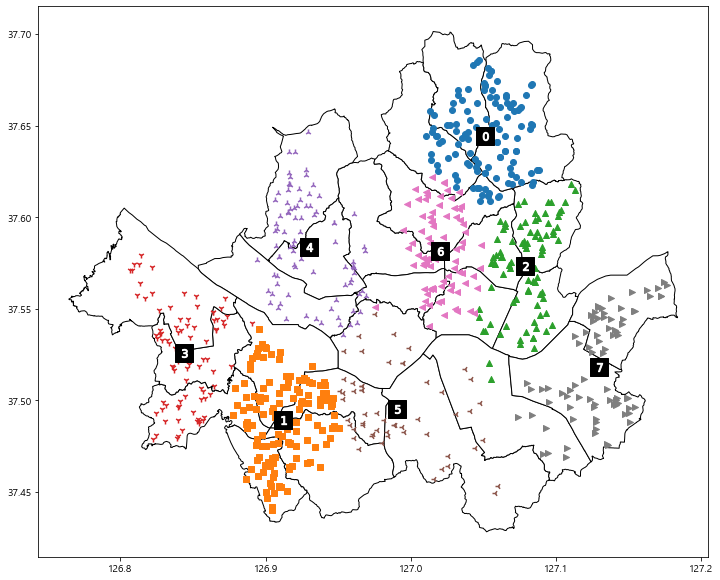

In [ ]:
ax = seoul.plot(color='white',edgecolor='black',figsize=(12,12))

care_cluster = care.iloc[:,[3,4]].astype('float')
kmeans = KMeans(n_clusters=8, init ='k-means++', max_iter = 300, random_state=0)
kmeans.fit(care_cluster)

care_cluster['target'] = kmeans.fit_predict(care_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','<','>','d','h']
for i in np.unique(care_cluster.target):
    target = care_cluster[care_cluster.target == i]        
    plt.scatter(x=target['Longitude'], y=target['Latitude'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

## 돌봄센터 자치구별 히트맵

In [ ]:
care_cnt = care.groupby('자치구').agg(count = ('자치구', 'count'))
care_cnt.reset_index(inplace = True)
care_cnt

,자치구,count
0,강남구,15
1,강동구,36
2,강북구,27
3,강서구,26
4,관악구,32
5,광진구,25
6,구로구,43
7,금천구,30
8,노원구,61
9,도봉구,24


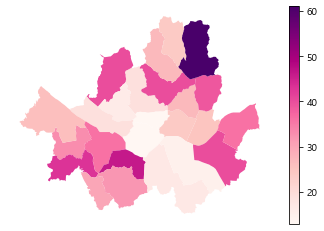

In [ ]:
care_cnt_heat = pd.merge(seoul,care_cnt,how='left', left_on='SIG_KOR_NM', right_on='자치구')

fig, ax = plt.subplots(1, 1)

care_cnt_heat.plot('count', ax=ax, legend=True, cmap='RdPu')
plt.axis('off')
plt.show()

# ** 군집화 최종 결과: 최적 군집개수

- cctv: 8
- 유흥주점: 8
- 단속카메라: 7
- 어린이 보호구역: 8 
- 병원: 6 
- 돌봄센터: 8